In [84]:
import pandas as pd
import numpy as np
import os
import traceback
import pdb
import configparser
np.seterr(all="ignore")
#--- user libs
import utility as utl
import imp
imp.reload(utl)


class Symbols:
    def __init__(self):
        self.colors = ['black','red','green','blue','cyan','brown','grey','magenta','orange','yellow']
        self.fillstyles=['white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None]
        self.markers=['o','s','D','^','<','>','v']
        self.markersizes=[10,10,10,12,12,12,10]
        self.nmax=7
        
    def GetAttrs(self,count=0,label='',nevery=1,fmt='.-',zorder=1):
        if count > self.nmax:
            print('index out of list bound!')
            return 
        attrs={ 'color':self.colors[count],
            'markersize':self.markersizes[count],
            'marker':self.markers[count],
            'markerfacecolor':self.colors[count],
            'markeredgecolor':'white', #'black' if not self.fillstyles[count] else None,
            'label':label,
           'markevery':nevery,
           'errorevery':nevery,
           'markeredgewidth':1.75,
            'linewidth':1, 
           'barsabove':None,
           'capsize':5,
           'capthick':1,
           'elinewidth':1,
           'fmt':fmt,
             'zorder':zorder,
         }
        return attrs
    
    def GetAttrs2nd(self,count=0,label='',nevery=1,fmt='.-',zorder=1):
        if count > self.nmax:
            print('index out of list bound!')
            return 
        attrs={ 'color':self.colors[count],
            'markersize':self.markersizes[count],
            'marker':self.markers[count],
            'markerfacecolor':'white',
#            'markeredgecolor':'black' if not self.fillstyles[count] else None,
            'label':label,
           'markevery':nevery,
           'errorevery':nevery,
           'markeredgewidth':1.75,
            'linewidth':1, 
           'barsabove':None,
           'capsize':5,
           'capthick':1,
           'elinewidth':1,
           'fmt':fmt,
            'zorder':zorder,
          }
        return attrs

class Legends:
    def __init__(self
                ):
        pass
    def Set(self,fontsize=20,
                 labelspacing=0,
                 **kwargs
#                 bbox_to_anchor=(0.5,0.48,0.5,0.5),
           ):
        self.attrs = {'frameon':False,'fontsize':fontsize,
                   'labelspacing':labelspacing,
                      'handletextpad':.2,
                   'handlelength':1,
                    **kwargs,
                     }
    def Get(self):
        return self.attrs

# set parameters
## load curves

In [141]:
parser = configparser.ConfigParser()
parser.read('config.ini')

path=parser['test data directory']['path']
#
inputFiles = os.listdir('%s'%(path))
print('inputFiles=',np.array(inputFiles))




inputFiles= ['tensile300k.txt' 'tensile700k.txt' 'tensile900k.txt' 'tensile600k.txt'
 'tensile800k.txt']


# Parse load curves

In [142]:
loadTimeSeries=list(map(lambda x:pd.DataFrame(np.c_[np.loadtxt('%s/%s'%(path,x))],
                columns=['Time','Stress']),inputFiles))
#--- read input file
#loadTimeSeries = list(map(lambda x:pd.read_csv('%s/%s'%(path,x),
#                 sep='\t',index_col=False,names=['Time','Depth','Force']),[inputFiles[0]]))
#--- derivative
#loadTimeSeries = list(map(lambda x:pd.DataFrame(np.c_[x,np.gradient(x.Depth,x.Time)],columns=['Time','Depth','Force','Rate']),loadTimeSeries))
loadTimeSeries[0] #--- index indicates the indenter location

,Time,Stress
0,3.498214e-14,-0.037254
1,1.000000e-05,-0.036465
2,2.000000e-05,-0.035594
3,3.000000e-05,-0.034639
4,4.000000e-05,-0.033637
...,...,...
799995,7.999950e+00,4.748868
799996,7.999960e+00,4.751020
799997,7.999970e+00,4.753173
799998,7.999980e+00,4.755352


# Plot timeseries

mkdir: png: File exists


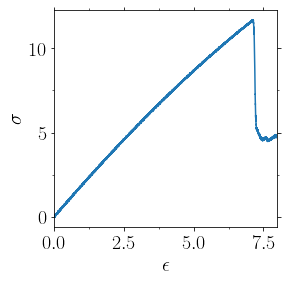

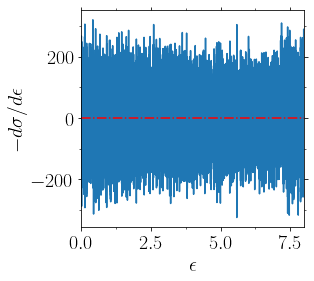

<AxesSubplot:xlabel='$\\epsilon$', ylabel='$-d\\sigma/d\\epsilon$'>

In [146]:
!mkdir png

#--- set limits
index = 0 #--- file index
ld = loadTimeSeries[ index ] #--- file id
# indentLabel, grainID = GetGrainId(indent,indentLabels,loadID,index)
# print('indent label:%s, grain id:%s'%(indentLabel,grainID))

#--- time
tlo = ld.Time.min()
thi = ld.Time.max()
# #--- load
# flo = 0
# fhi = 1.01*ld['Force'][ld['Time']<thi].max() #ld.Force.max()
# #--- depth
# hlo = 0.0
# hhi = ld['Depth'][ld['Time']<thi].max() #ld.Depth.max()
# #--- velocity
# vlo = 0.0
# vhi = ld.Rate[ld.Rate!=np.inf].max()

#--- load vs. time
utl.PltErr(ld.Time, ld.Stress,
           attrs={'fmt':'-'},
            xlim=(tlo,thi),
#            ylim=(flo,fhi),
           xstr=r'$\epsilon$',
           ystr=r'$\sigma$',
           title='png/stress_timeseries.png'
          )

ax=utl.PltErr(ld.Time, -np.gradient(ld.Stress,ld.Time),
           attrs={'fmt':'-'},
            Plot=False,
          )

utl.PltErr([tlo,thi],[0,0],
           attrs={'fmt':'-.r'},
            xlim=(tlo,thi),
#            ylim=(flo,fhi),
           xstr=r'$\epsilon$',
           ystr=r'$-d\sigma/d\epsilon$',
           ax=ax,
           title='png/stress_derivative.png'
          )


## output timeseries

# Avalanche statistics

## Avalanche size

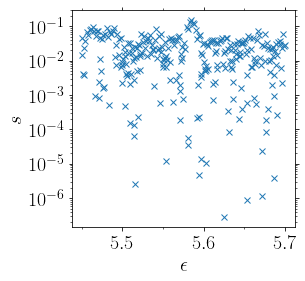

<AxesSubplot:xlabel='$\\epsilon$', ylabel='$s$'>

In [144]:
def Wrapper_GetAvl(ld,tlo,thi,lambdc):
    '''
    return avalanche sizes given force timeseries and initial and final times
    '''
    
#    print(np.min(GetPower(ld,tlo,thi)))
    
    #--- data frame storing avalanche attributes
    filtr = np.all([ld.Time>tlo,ld.Time<thi],axis=0)

    df_avl = utl.GetAvl( np.array(ld.Time[filtr]), -np.gradient(ld.Stress,ld.Time)[filtr], lambdc)
    #df_avl = GetAvalKunMethod( broken_bonds,  5) #tcrltn )

    #--- save
    # df_fltrd = DataFrameSubSet( df_avl, #--- filter
    #                               'ti', 
    #                               ( 0, tavl ) ) 
    # df_fltrd.to_pickle('df_avl.pk')

#    display( df_avl.sort_values( by = 'size',ascending = False) )
#    print ('n.avls = %s'%len(df_avl))
    return df_avl #np.array(df_avl['size'].to_list())
    
lambdc = 0.0 #--- threshold
temps=['300']#,'600','700','800','900']
try:
#    df_avl = np.concatenate(list(map(lambda x:Wrapper_GetAvl(x,tlo,thi,lambdc), loadTimeSeries)))
    df_avl = dict(zip(temps,list(map(lambda x:Wrapper_GetAvl(x,tlo,thi,lambdc), loadTimeSeries))))
#    df_avl = Wrapper_GetAvl(ld,tlo,thi,lambdc)
except:
    print('increase the threshold')
    
    

utl.PltErr(df_avl['300']['tf'],df_avl['300']['size'],
           attrs={'fmt':'x'},
#             xlim=(tlo,thi),
#            ylim=(flo,fhi),
           xstr=r'$\epsilon$',
           ystr=r'$s$',
           yscale='log',
           title='png/size.png'
          )


### pdf

/Users/Home/Desktop/Tmp/txt/git/DislocationAvalanches/tensile/python/utility.py:1927: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string ".-" (-> marker='.'). The keyword argument will take precedence.
  ax.errorbar( xdata, ydata,yerr = yerr, xerr = xerr, **kwargs['attrs'])


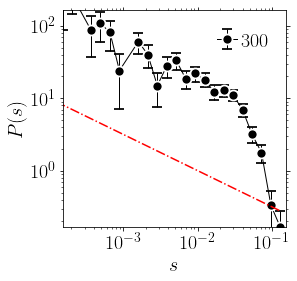

<AxesSubplot:xlabel='$s$', ylabel='$P(s)$'>

In [145]:
ax = utl.PltErr(None,None,Plot=False)
symbols=Symbols()
legend=Legends()
legend.Set(fontsize=20,
                 labelspacing=0,
                 bbox_to_anchor=(0.5,0.48,0.5,0.5),
           )

for count,temp in zip(range(len(df_avl)),temps):
    sizes = df_avl[temp]['size']
    smax = np.max(sizes)
    hist, edge, err = utl.GetPDF(sizes, n_per_decade=8, linscale=None)

    utl.PltErr(edge, hist, yerr=err,Plot=False,ax=ax,
               attrs=symbols.GetAttrs(count=count,label=r'$%s$'%temp))

alpha=0.5
utl.PltErr(edge, 1e-1/edge**alpha,
           attrs={'fmt':'-.r'},
#           xlim=(1e-3,1e1),
#            ylim=(1e-2,1e2),
           ystr=r'$P(s)$',
           xstr=r'$s$',
           xscale = 'log',
           yscale='log',
            xlim=(1.0e-3*smax,smax),
            ylim=(hist.min(),hist.min()*1e3),
           ax=ax,
           title='png/ps.png',
            legend=legend.Get()
          )

### vary threshold

In [347]:
def varyThreshold(loadTimeSeries, tlo, thi, lambdc):
    return np.concatenate(list(map(lambda x:Wrapper_GetAvl(x,tlo,thi,lambdc), loadTimeSeries)))

try:
    lambdc = np.logspace(np.log10(1.0e1),np.log10(3.0e1),4)
    size_lambdc = list(map(lambda x:varyThreshold(loadTimeSeries, tlo, thi, x),lambdc))

    #--- distributions
    hists = list(map(lambda x: utl.GetPDF(x, n_per_decade=8, linscale=None), size_lambdc))


    for item, threshold, indx in zip(hists, lambdc, range(len(hists))):
        hist, edge, err = item
        if indx == 0:
            ax = utl.PltErr(edge, hist, yerr=err,
                            Plot = False,
                            legend = True,
                            label=r'$\lambda_c=%3.2f$'%threshold,
                      )
            ax = utl.PltErr(edge, 1/edge**1.3,
                            Plot = False,
                            fmt = '-.r',
                            ax = ax,
                      )
        else:
            ax = utl.PltErr(edge, hist, yerr=err,
    #                        xlim=(1e-3,1e1),
    #                       ylim=(1e-2,1e2),
                           ystr=r'$P(s)$',
                           xstr=r'$s$',
                           xscale = 'log',
                           yscale='log',
                           Plot = False,
                           ax=ax,
                           label=r'$\lambda_c=%3.2f$'%threshold,
                            legend = True,
                            loc=3,
                            fontsize=16,
                           title='avalanche_size.png'
                          )
except:
    print('increase the threshold')

increase the threshold


In [348]:
input_file = '/Users/Home/Desktop/Tmp/txt/git/DislocationAvalanches/nanoindentation/ebsd/attributes.txt'
grain_attr = pd.read_csv(input_file,sep='\t')
grain_attr.head()

,#grainID,x,y,grainSize,perimeter,boundarySize,numNeighbors
0,1,-0.018954,0.068387,1,3.695012,5,1
1,2,-85.909030,-0.799994,1,2.771259,6,1
2,3,-85.909030,-2.399981,1,2.771259,6,2
3,4,-141.335700,-0.852774,10,13.056300,24,3
4,5,-85.909030,-3.199974,1,2.771259,6,3


In [349]:
def Wrapper(index):
    #index = 0 #--- file index
    ld = loadTimeSeries[ index ] #--- file id
    indentLabel = indentLabels[index]

    grainLabel = grainLabels[loadID][indentLabel]
    print('indent label:%s, grain label:%s'%(indentLabel,grainLabel))

    lambdc = 10.0
    avlanche = Wrapper_GetAvl(ld,tlo,thi,lambdc)
    moment_1st = np.mean(avlanche)
    avalanche_sq = avlanche*avlanche
    moment_2nd = np.mean(avalanche_sq)**0.5
    avalanche_4th = avalanche_sq*avalanche_sq
    moment_4th = np.mean(avalanche_4th)**0.25

    grainSize = grain_attr[ grain_attr['#grainID'] == grainLabel ].grainSize
#    pdb.set_trace()
    return grainSize.iloc[0], moment_1st, moment_2nd, moment_4th


#val = np.c_[list(map(lambda x:Wrapper(x),range(len(loadTimeSeries))))]
# utl.PltErr(utl.Zscore(val[:,0]),utl.Zscore(val[:,1]),
#           attrs={'fmt' : '.',
#           'markersize':10.0},
#             xstr=r'grain size',
#             ystr=r'1st moment',
#            xlim=(-3,3),
#            ylim=(-3,3),
#           )

# utl.PltErr(utl.Zscore(val[:,0]),utl.Zscore(val[:,2]),
#           attrs={'fmt' : '.',
#           'markersize':10.0},
#             xstr=r'grain size',
#             ystr=r'2nd moment',
#            xlim=(-3,3),
#            ylim=(-3,3),
#           )
# utl.PltErr(val[:,0],val[:,2],
#           attrs={'fmt' : '.',
#           'markersize':10.0},
#             xstr=r'grain size',
#             ystr=r'avalanche size(2nd moment)',
#            title='avalancheSize.png'
# #           xlim=(-3,3),
# #           ylim=(-3,3),
#           )

# utl.PltErr(utl.Zscore(val[:,0]),utl.Zscore(val[:,3]),
#           attrs={'fmt' : '.',
#           'markersize':10.0},
#             xstr=r'grain size',
#             ystr=r'4th moment',
#            xlim=(-3,3),
#            ylim=(-3,3),
#           )
